In [7]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [8]:
# 1. Загрузка данных
# Допустим, у нас есть датасет в формате numpy: x_train (набор изображений)

# Загрузим датасет для примера (здесь мы используем MNIST для упрощения)
(x_train, _), (_, _) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28, 28, 1))

# 2. Создание модели VAE

latent_dim = 2  # Размерность латентного пространства

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(decoder_inputs, decoder_outputs, name="decoder")

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling((z_mean, z_log_var))
        return self.decoder(z)

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

vae = VAE(encoder, decoder)
vae.compile(optimizer='adam', loss='mse')

# 3. Обучение VAE
vae.fit(x_train, x_train, epochs=10, batch_size=32)

# 4. Применение VAE для переноса стиля

Epoch 1/10
1875/1875 [==============================] - 35s 18ms/step - loss: 0.0525
Epoch 2/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0435
Epoch 3/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0418
Epoch 4/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0408
Epoch 5/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0401
Epoch 6/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0396
Epoch 7/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0392
Epoch 8/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0389
Epoch 9/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0387
Epoch 10/10
1875/1875 [==============================] - 35s 18ms/step - loss: 0.0385


In [36]:
def transfer_style(content_image_path, style_image_path):
    content_image = image.load_img(content_image_path, target_size=(28, 28))
    content_image = image.img_to_array(content_image)
    content_image = cv2.cvtColor(content_image, cv2.COLOR_BGR2GRAY)
    content_image = content_image.astype('float32') / 255.
    content_image = np.expand_dims(content_image, axis=0)

    style_image = image.load_img(style_image_path, target_size=(28, 28))
    style_image = image.img_to_array(style_image)
    style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2GRAY)
    style_image = style_image.astype('float32') / 255.
    style_image = np.expand_dims(style_image, axis=0)

    content_encoded = encoder.predict(content_image)[0]
    style_encoded = encoder.predict(style_image)[0]

    # Здесь можно выполнить комбинирование латентных переменных для переноса стиля
    # Например, используя простое усреднение (для демонстрации)
    combined_encoded = 0.01*content_encoded + 0.99*style_encoded

    transferred_image = decoder.predict(combined_encoded)

    return transferred_image

# # Применяем функцию для демонстрации переноса стиля
# result_image = transfer_style('path_to_content_image.jpg', 'path_to_style_image.jpg')

In [37]:
# Применяем функцию для демонстрации переноса стиля
result_image = transfer_style('letter.jpg', 'letter1.jpg')

1/1 [==============================] - 0s 17ms/step


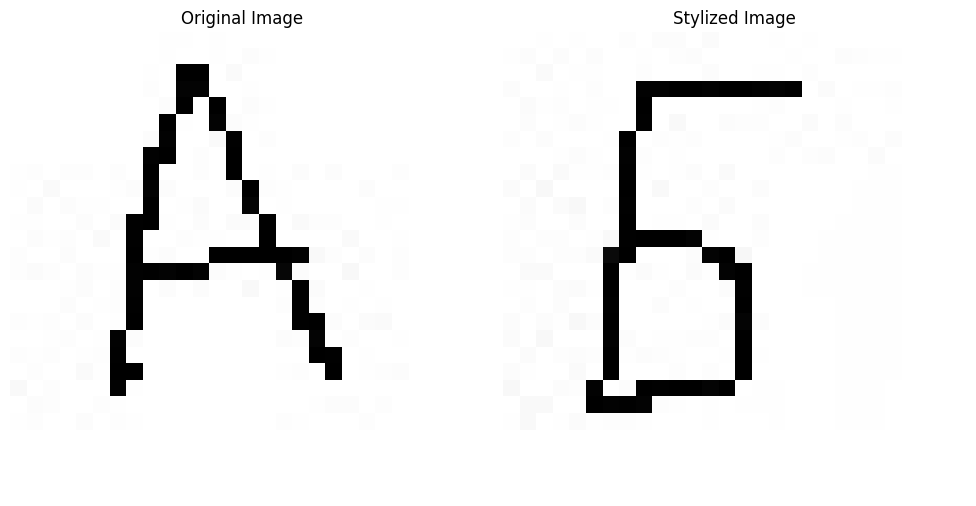

In [38]:
import matplotlib.pyplot as plt

def display_images(original, stylized):
    plt.figure(figsize=(10, 5))

    # Отображение исходного изображения
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis('off')

    # Отображение стилизованного изображения
    plt.subplot(1, 2, 2)
    plt.imshow(stylized)
    plt.title("Stylized Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Пример использования
original_image = plt.imread('letter.jpg')
stylized_image = plt.imread('letter1.jpg')
display_images(original_image, stylized_image)


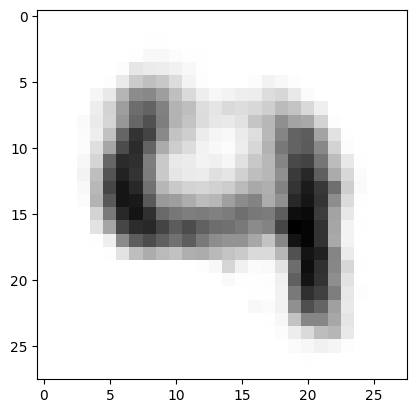

In [39]:
plt.imshow(1-result_image[0,...], cmap='gray')
plt.show()

In [17]:
result_image.shape

(1, 28, 28, 1)